# Decision Tree Classifier

## Importações

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings("ignore")

np.random.seed(777)

## Funções Principais

In [2]:
def prepare_train(path: str, selector) -> list:
    df_train = pd.read_csv(path)
    X_train = df_train.loc[:, df_train.columns != 'Target']
    y_train = df_train['Target']

    X_train = selector.fit_transform(X_train, y_train)
    return X_train, y_train


def prepare_test(path: str, selector) -> list:
    df_test = pd.read_csv(path)
    X_test = df_test.loc[:, df_test.columns != 'Target']
    y_test = df_test['Target']

    X_test = selector.transform(X_test)
    return X_test, y_test


def get_best_clf(clf, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

    scorer = make_scorer(f1_score, pos_label='Dropout')

    cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring=scorer)

    print(f'Scores de F1 para cada fold: {cv_scores}')
    print(f'Média do F1-score: {cv_scores.mean()}')
    print(f'Desvio padrão do F1-score: {cv_scores.std()}')

    best_clf.fit(X_train, y_train)

    print("Melhores hiperparâmetros encontrados:")
    print(grid_search.best_params_)

    f1 = cv_scores.mean()

    return best_clf, f1


def print_clf_score(best_clf, X_test, y_test):
    y_pred = best_clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=['Dropout', 'Graduate_or_Enrolled'])
    labels = ['Dropout', 'Graduate_or_Enrolled']

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.xticks(np.arange(len(labels)) + 0.5, labels)
    plt.yticks(np.arange(len(labels)) + 0.5, labels)
    plt.show()


def dump_model(best_clf, model_path, X_test, y_test, f1):
    y_pred = best_clf.predict(X_test)
    a = accuracy_score(y_test, y_pred)
    joblib.dump(best_clf, f'{model_path}a{int(100*a)}_f{int(100*f1)}.pkl')

In [3]:
train_path = '../data/preprocessed/train-validation/'
test_path = '../data/preprocessed/test/'
models_path = '../models-dump/'

## DTREE

### Padrão

Scores de F1 para cada fold: [0.75810474 0.76705882 0.7654321  0.73636364 0.73182957]
Média do F1-score: 0.7517577741495861
Desvio padrão do F1-score: 0.014802066476518999
Melhores hiperparâmetros encontrados:
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


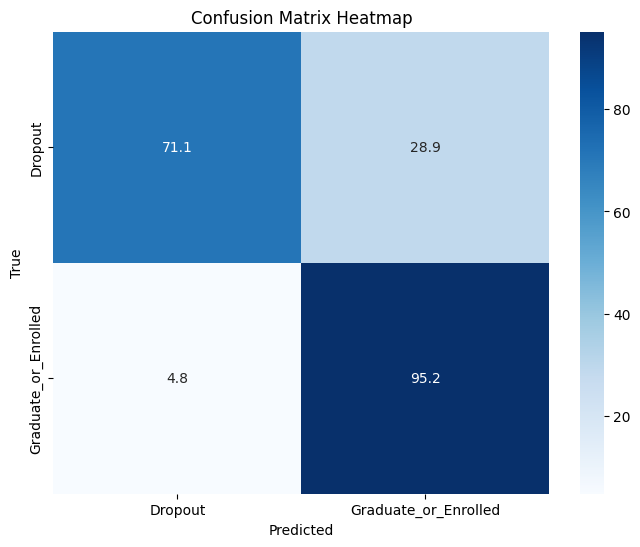

In [4]:
data_config = 'drp_XOHE_scld.csv'

clf = DecisionTreeClassifier()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'decision-tree/', X_test, y_test, f1)

### Rebalanceado

Scores de F1 para cada fold: [0.87868852 0.88288288 0.89309577 0.87336245 0.86101695]
Média do F1-score: 0.8778093140829203
Desvio padrão do F1-score: 0.010601395730642138
Melhores hiperparâmetros encontrados:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


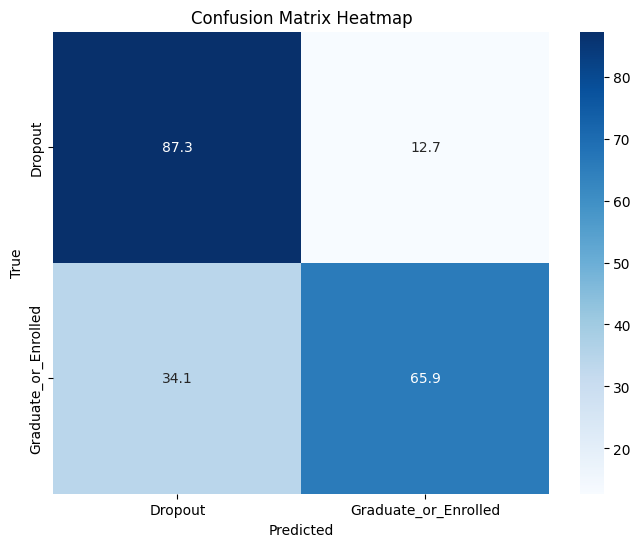

In [5]:
data_config = 'drp_XOHE_scld.csv'

clf = DecisionTreeClassifier()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'decision-tree/', X_test, y_test, f1)

## Naive Bayes

### Padrão

Scores de F1 para cada fold: [0.53395785 0.59860789 0.57943925 0.63133641 0.51173709]
Média do F1-score: 0.5710156962265251
Desvio padrão do F1-score: 0.04326224891587388
Melhores hiperparâmetros encontrados:
{'alpha': 1}


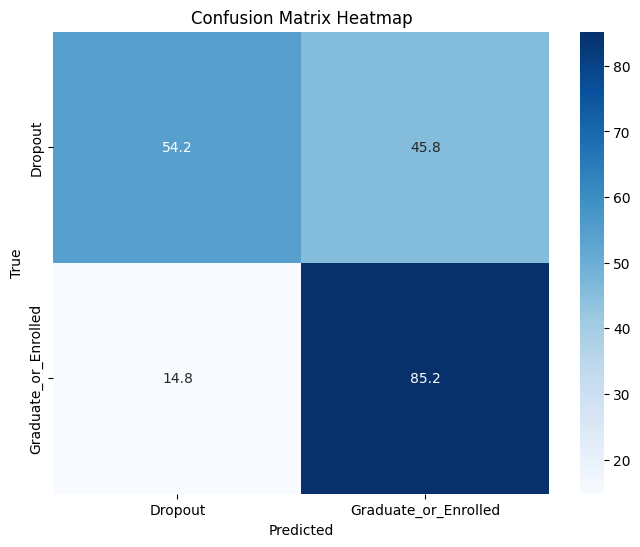

In [6]:
data_config = 'drp_XOHE_scld.csv'

clf = MultinomialNB()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'alpha': [.1, 1, 5, 10, 1000]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'naive-bayes/', X_test, y_test, f1)

### Rebalanceado

Scores de F1 para cada fold: [0.74376417 0.7347876  0.75736961 0.74385965 0.73659674]
Média do F1-score: 0.7432755546053718
Desvio padrão do F1-score: 0.007948262878588979
Melhores hiperparâmetros encontrados:
{'alpha': 0.1}


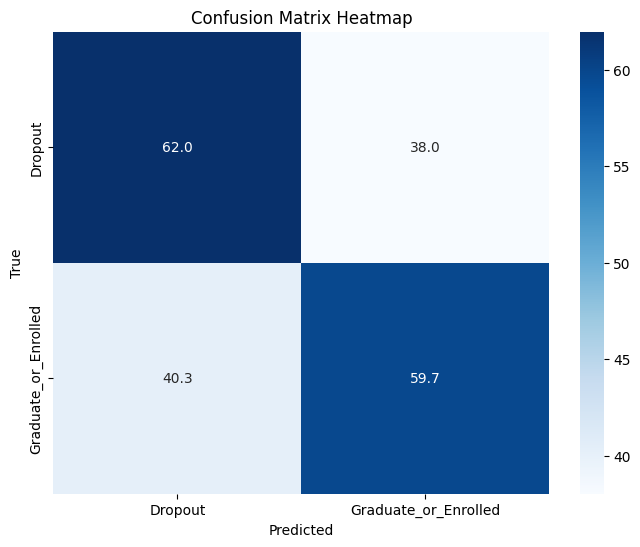

In [7]:
data_config = 'drp_XOHE_scld.csv'

clf = MultinomialNB()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'alpha': [.1, 1, 5, 10, 1000]
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'naive-bayes/', X_test, y_test, f1)

## Logistic Regression

### Padrão

Scores de F1 para cada fold: [0.78321678 0.77541371 0.79146919 0.76122931 0.72771084]
Média do F1-score: 0.7678079693815603
Desvio padrão do F1-score: 0.022388348035097854
Melhores hiperparâmetros encontrados:
{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


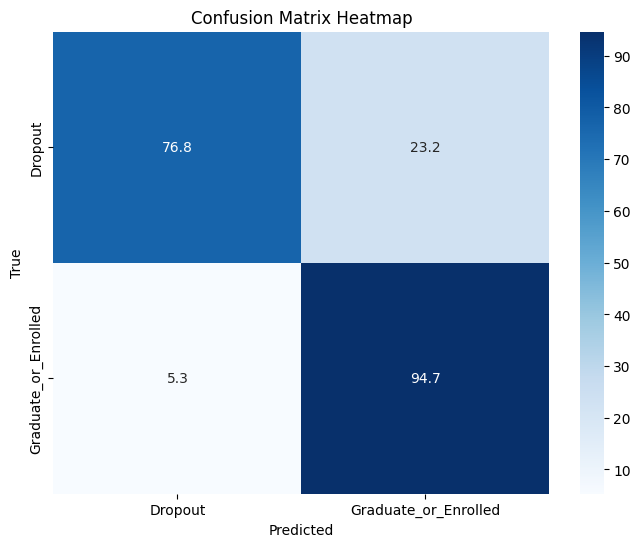

In [8]:
data_config = 'drp_XOHE_scld.csv'

clf = LogisticRegression()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+data_config, selector)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None, {
        'Dropout': 2,
        'Graduate_or_Enrolled': 1
    }],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'logistic-regression/', X_test, y_test, f1)

### Rebalanceado

Scores de F1 para cada fold: [0.87289089 0.87372014 0.87586207 0.85714286 0.8463357 ]
Média do F1-score: 0.8651903297331186
Desvio padrão do F1-score: 0.011542973663944004
Melhores hiperparâmetros encontrados:
{'C': 1000, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cholesky'}


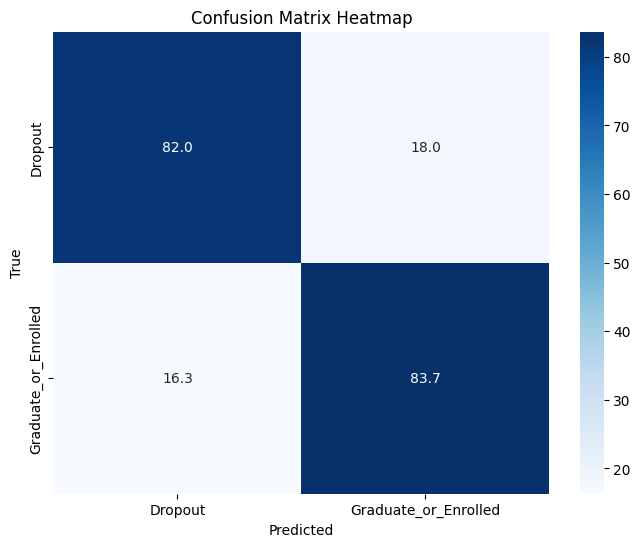

In [9]:
data_config = 'drp_XOHE_scld.csv'

clf = LogisticRegression()

selector = SelectKBest(score_func=f_classif, k='all')

X_train, y_train = prepare_train(train_path+'rebalanced/'+data_config, selector)

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [.1, 1, 10, 100, 1000],
    'class_weight': ['balanced', None, {
        'Dropout': 2,
        'Graduate_or_Enrolled': 1
    }],
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky']
}

best_clf, f1 = get_best_clf(clf, param_grid, X_train, y_train)

X_test, y_test = prepare_test(test_path+data_config, selector)

print_clf_score(best_clf, X_test, y_test)

dump_model(best_clf, models_path+'logistic-regression/', X_test, y_test, f1)

## Loading best model

In [10]:
loaded_clf = joblib.load(f'{models_path}logistic-regression/a83_f86.pkl')

# Avaliar o modelo carregado
print("Accuracy of loaded model on test set:", loaded_clf.score(X_test, y_test))

Accuracy of loaded model on test set: 0.831638418079096
